# Static link prediction
In this notebook, we will apply models from the PyKEEN package to generate link predictions on the entire graph as a static object.

In [3]:
import networkx as nx
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.losses import BCEWithLogitsLoss
from pykeen.constants import PYKEEN_CHECKPOINTS
import torch
from pykeen.models import RESCAL
from itertools import combinations
from tqdm import tqdm
import json
import pandas as pd
from collections import Counter, defaultdict
from scipy.stats import randint
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, RocCurveDisplay, auc, roc_curve
from sklearn.decomposition import PCA
import pickle
from pykeen import predict
from random import choice, sample
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import numpy as np
from itertools import cycle
from ast import literal_eval
from scipy.stats import ttest_ind, kstest
from scipy.spatial.distance import cdist, squareform
from scipy.special import softmax
import functools

2024-07-17 10:17:41.508820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read in the PyKEEN tensors
Training a PyKEEN model on a graph this size takes a while, so we submitted it as a job. Here, we'll read in the final checkopint to re-instantiate the trained model, and use it to build our prediction mechanism.

### Drought + DT

In [4]:
model_save_suffix = 'BCE_loss'
split_random_seed = 1234 # From the training output file
model_random_seed = 5678 # From the training output file
date = '14Jul2024'

In [5]:
checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath(f'dt_rescal_{model_save_suffix}_{date}.pt'), map_location=torch.device('cpu'))

In [6]:
def get_predicate(row):
    if row.is_drought:
        if row.is_desiccation:
            return 'both'
        else:
            return 'drought'
    else:
        if row.is_desiccation:
            return 'desiccation'

In [7]:
graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_No_quotes_12Jun2024.graphml')
edgelist = nx.to_pandas_edgelist(graph)
edgelist['predicate'] = edgelist.apply(get_predicate, axis=1)
triples = edgelist[['source', 'predicate', 'target']].to_numpy()
print(f'Snapshot of triples: {triples[:5]}')

Snapshot of triples: [['peg-induced drought tolerance' 'drought' 'sesame']
 ['peg-induced drought tolerance' 'drought' 'sesame drought tolerance']
 ['peg-induced drought tolerance' 'drought' 'otsa']
 ['peg-induced drought tolerance' 'drought' 'p5cr']
 ['peg-induced drought tolerance' 'drought' 'glgx']]


In [8]:
tf = TriplesFactory.from_labeled_triples(triples,
                                         create_inverse_triples=True,
                                         entity_to_id=checkpoint['entity_to_id_dict'],
                                         relation_to_id=checkpoint['relation_to_id_dict'])
training, validation, testing = tf.split([0.8, 0.1, 0.1], random_state=split_random_seed)

In [9]:
my_model = RESCAL(triples_factory=training, random_seed=model_random_seed)
my_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Common-sense check of the loss curves and validation metrics. To do this, we need to load in a pipeline result object, rather than just the model like we have above. The below code requires GPU, so make sure the Jupyter kernel is initialized with GPU.

In [9]:
# result = pipeline(training=training,
#                   validation=validation,
#                   testing=testing,
#                   stopper='early',
#                   model='RESCAL',
#                   model_kwargs=dict(entity_initializer="normal",
#                       relation_initializer="normal"),
#                   loss=BCEWithLogitsLoss,
#                   training_kwargs=dict(
#                       num_epochs=25,
#                       checkpoint_name=f'dt_rescal_{model_save_suffix}.pt',
#                       checkpoint_frequency=0))

In [10]:
# result.plot_losses()

In [11]:
# result.plot_early_stopping()

hits@K is very small, but since the losses plot looks relatively normal, I don't think there's much I can do about it in terms of HPO; so we will move ahead with this model.

### Genophenoenvo

In [10]:
gpe_model_save_suffix = 'BCE_loss'
gpe_split_random_seed = 1234
gpe_model_random_seed = 5678
gpe_date = '14Jul2024'

In [11]:
gpe_graph = nx.read_graphml('../data/genophenoenvo/genophenoenvo_from_edge_and_nodelist.graphml')
gpe_edgelist = nx.to_pandas_edgelist(gpe_graph)
gpe_triples = gpe_edgelist[['source', 'predicate', 'target']].to_numpy()
print(f'Snapshot of triples: {gpe_triples[:5]}')

Snapshot of triples: [['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000207']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000919']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000396']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000352']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000478']]


In [12]:
gpe_checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath(f'gpe_rescal_{gpe_model_save_suffix}_{date}.pt'), map_location=torch.device('cpu'))

In [13]:
gpe_tf = TriplesFactory.from_labeled_triples(gpe_triples,
                                         create_inverse_triples=True,
                                         entity_to_id=gpe_checkpoint['entity_to_id_dict'],
                                         relation_to_id=gpe_checkpoint['relation_to_id_dict'])
gpe_training, gpe_validation, gpe_testing = gpe_tf.split([0.8, 0.1, 0.1], random_state=gpe_split_random_seed)

In [14]:
gpe_model = RESCAL(triples_factory=gpe_training, random_seed=gpe_model_random_seed)
gpe_model.load_state_dict(gpe_checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
## REQUIRES GPU
# gpe_result = pipeline(training=gpe_training,
#                   validation=gpe_validation,
#                   testing=gpe_testing,
#                   stopper='early',
#                   model='RESCAL',
#                   model_kwargs=dict(entity_initializer="normal",
#                       relation_initializer="normal"),
#                   loss=BCEWithLogitsLoss,
#                   training_kwargs=dict(
#                       num_epochs=25,
#                       checkpoint_name=f'dt_rescal_{gpe_model_save_suffix}.pt',
#                       checkpoint_frequency=0))

In [18]:
# gpe_result.plot_losses()

In [19]:
# gpe_result.plot_early_stopping()

## Using PyKEEN built-in prediction
It looks like a simple RF model with just the node embeddings isn't going to cut it for prediction. Let's try the built-in PyKEEN prediction methods and see if we can do any better.

The tricky thing about link prediction is choosing *what to predict*. In the above RF case, we asked about a (relatively) random set of 8,000 triples in the test set. In PyKEEN, while there is an option to `predict_all` triples, it's very computationally expensive because it involves calculating the score for every single possible triple. Therefore, we can do a few different things, like, given a head entity, predict the likelihood of anything being a tail entity, or get scores for a list of triples. For the sake of being able to compare these results with the RF model above, let's ask it to predict the types of the triples in the same test set. Since it wants a predicate for a given triple, we will choose predicates randomly from the three options for the negative samples.

### Drought + DT

We will use the same test set here as we did for the RF models that we ran outside of this notebook, so that all models are comparable. PyKEEN requires that the negative instances still have a predicate. Because we used the random sampling strategy to generate the negative set for the test set, we will also randomly sample predicates to place in each negative triple.

In [35]:
positive_test_triples = [
    (t[0], p, t[1])
    for p, trips in test_pairs['positives'].items()
    for t in trips
]
negative_test_triples = [
    (t[0], p, t[1])
    for p, trips in test_pairs['negatives'].items()
    for t in trips
]

In [90]:
## RANDOM SAMPLING METHOD
# # Restore the ones from the saved training data
# train_pairs = {lab: [literal_eval(tup) for tup in train_df[train_df['label'] == label_map[lab]].index.tolist()] for lab in label_map.keys()}
# test_pairs = {lab: [literal_eval(tup) for tup in test_df[test_df['label'] == label_map[lab]].index.tolist()] for lab in label_map.keys()}

# test_trips = []
# negative_trips = []
# for lab, pairs in test_pairs.items():
#     if lab == 'negative':
#         predicate = choice(['desiccation', 'drought', 'both'])
#         negative_trips.extend([(pair[0], predicate, pair[1]) for pair in pairs])
#     else:
#         predicate = lab
#     test_trips.extend([(pair[0], predicate, pair[1]) for pair in pairs])

In [58]:
scores = predict.predict_triples(
    model=my_model,
    triples=positive_test_triples + negative_test_triples,
    triples_factory=testing,
)

Using maximize_memory_utilization on non-CUDA tensors. This may lead to undocumented crashes due to CPU OOM killer.


In [59]:
score_df = scores.process(testing).df

In [60]:
score_df = score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
score_df.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,71540,corticolous bryophytes,0,both,21893,antarctic beech ( nothofagus moorei,0.000010
1,61377,chi a fluorescence emission,0,both,196397,parmelia quercina ( willd,0.000007
2,168998,mormon crickets,0,both,290264,wheatme,0.000007
3,15110,agapanthus praecox,0,both,198621,pec3h74,0.000007
4,67295,cml444,0,both,11586,ac7729tzsrw,0.000005


Add back a column to check which triples were supposed to be negative:

In [61]:
def is_negative(row):
    if (row.head_label, row.relation_label, row.tail_label) in negative_test_triples:
        return True
    else:
        return False

In [62]:
score_df['is_negative'] = score_df.apply(is_negative, axis=1)

In [63]:
score_df.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,is_negative
0,71540,corticolous bryophytes,0,both,21893,antarctic beech ( nothofagus moorei,0.000010,False
1,61377,chi a fluorescence emission,0,both,196397,parmelia quercina ( willd,0.000007,False
2,168998,mormon crickets,0,both,290264,wheatme,0.000007,True
3,15110,agapanthus praecox,0,both,198621,pec3h74,0.000007,True
4,67295,cml444,0,both,11586,ac7729tzsrw,0.000005,False


Since we used `BCEWithLogitsLoss`, the scores were optimized around a global threshold of 0 to separate positive and negative triples. Any triple with a positive score should be a true triple, and a negative score means they should be negative. Let's take a look at the score distributions to see if this is the case:

We want to see where the negative triples rank in the scoring. We would like them to be at the bottom if the model is performing well:

In [64]:
neg_scores = score_df[score_df['is_negative']].score.tolist()
pos_scores = score_df[~score_df['is_negative']].score.tolist()

Text(0.5, 0.01, 'Score')

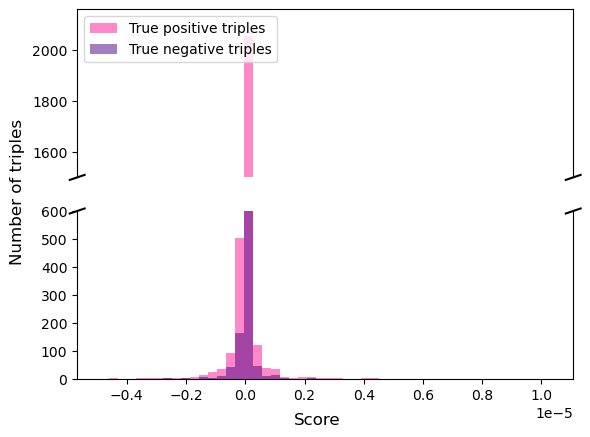

In [65]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

bins = np.histogram(np.hstack((pos_scores, neg_scores)), bins=50)[1]

_ = ax1.hist(pos_scores, bins, color='deeppink', alpha=0.5, label='True positive triples')
_ = ax1.hist(neg_scores, bins, color='indigo', alpha=0.5, label='True negative triples')
_ = ax2.hist(pos_scores, bins, color='deeppink', alpha=0.5, label='True positive triples')
_ = ax2.hist(neg_scores, bins, color='indigo', alpha=0.5, label='True negative triples')

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-3]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 600) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False, top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

_ = ax1.legend(loc='upper left')
fig.supylabel('Number of triples')
fig.supxlabel('Score')
plt.savefig(f'../data/figures/dt_triple_score_distributions_{model_save_suffix}.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [66]:
neg_ranks = score_df[score_df['is_negative']].index.tolist()

In [67]:
pos_ranks = score_df[~score_df['is_negative']].index.tolist()

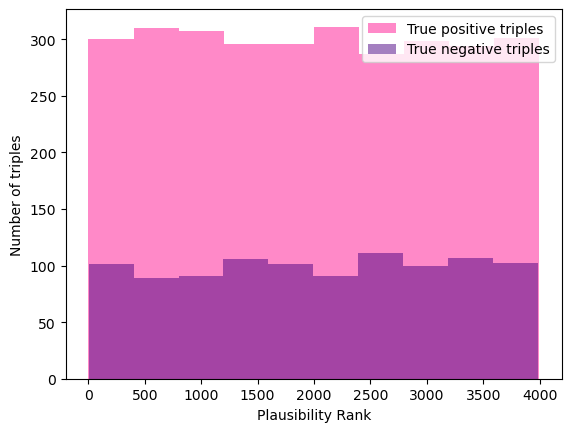

In [68]:
fig, ax = plt.subplots()

ax.hist(pos_ranks, color='deeppink', alpha=0.5, label='True positive triples')
ax.hist(neg_ranks, color='indigo', alpha=0.5, label='True negative triples')
ax.set_xlabel('Plausibility Rank')
ax.set_ylabel('Number of triples')
ax.legend()
plt.savefig(f'../data/figures/dt_triple_rankings_{model_save_suffix}.pdf', format='pdf', dpi=600, bbox_inches='tight')

Unfortunately, both kinds of triples are at both ends of the ranking spectrum. However, we see that negative and positive triples display somewhat different patterns of rank distribution. Whereas negative triples are most often scoring in the middle of the pack, positive triples either score on the high-ranked end or the low-ranked end, but not so much in the middle. This is likely an artefact of there being many more negative triples with scores near 0 than positive triples; they tend to "crowd out" the positive triples in the center of the ranking.

t-test to see if the means of the distributions are the same:

In [69]:
ttest_ind(pos_scores, neg_scores)

TtestResult(statistic=-0.5639574504794637, pvalue=0.5728147304192227, df=3997.0)

KS test to see if the distributions are the same:

In [70]:
kstest(pos_scores, neg_scores)

KstestResult(statistic=0.029767767767767767, pvalue=0.508498362231263, statistic_location=-4.265595432428881e-09, statistic_sign=-1)

We have one pre-defined threshold at 0, which is what the loss function optimized around during training. Let's calculate the F1 score if we use this threshold:

In [ ]:
## TODO

### Genophenoenvo

In [53]:
types_to_exclude = [k for k, v in gpe_train_ent_types.items() if v < 2000]

In [54]:
gpe_train_pairs = get_class_pairs(gpe_train_trips_semantic, num_inst=2000, types_to_exclude=types_to_exclude, sampling_method='embedding', node_reps=gpe_model.entity_representations[0](), ent_map=gpe_checkpoint['entity_to_id_dict'])
gpe_test_pairs = get_class_pairs(gpe_test_trips_semantic, num_inst=1000, types_to_exclude=types_to_exclude, sampling_method='embedding', node_reps=gpe_model.entity_representations[0](), ent_map=gpe_checkpoint['entity_to_id_dict'])

100%|██████████| 12/12 [00:25<00:00,  2.10s/it]


4 entity types have less than the requested number of instances. They will be returned with the number that they have.


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


In [55]:
with open('../data/ml_inputs/gpe_training_triples_with_neg_predicates.json', 'w') as f:
    json.dump(gpe_train_pairs, f)
with open('../data/ml_inputs/gpe_testing_triples_with_neg_predicates.json', 'w') as f:
    json.dump(gpe_test_pairs, f)

In [56]:
gpe_positive_test_triples = [
    (t[0], p, t[1])
    for p, trips in gpe_test_pairs['positives'].items()
    for t in trips
]
gpe_negative_test_triples = [
    (t[0], p, t[1])
    for p, trips in gpe_test_pairs['negatives'].items()
    for t in trips
]

In [153]:
# gpe_all_labels = list(gpe_label_map.keys())
# gpe_all_labels.remove('negative')

In [154]:
## RANDOM sampling method
# # Restore the ones from the saved training data
# gpe_train_pairs = {lab: [literal_eval(tup) for tup in gpe_train_df[gpe_train_df['label'] == gpe_label_map[lab]].index.tolist()] for lab in gpe_label_map.keys()}
# gpe_test_pairs = {lab: [literal_eval(tup) for tup in gpe_test_df[gpe_test_df['label'] == gpe_label_map[lab]].index.tolist()] for lab in gpe_label_map.keys()}

# # Assign arbitrary predicate to the negative triples
# gpe_test_trips = []
# gpe_negative_trips = []
# for lab, pairs in gpe_test_pairs.items():
#     if lab == 'negative':
#         predicate = choice(gpe_all_labels)
#         gpe_negative_trips.extend([(pair[0], predicate, pair[1]) for pair in pairs])
#     else:
#         predicate = lab
#     gpe_test_trips.extend([(pair[0], predicate, pair[1]) for pair in pairs])

In [57]:
gpe_scores = predict.predict_triples(
    model=gpe_model,
    triples=gpe_positive_test_triples + gpe_negative_test_triples,
    triples_factory=gpe_testing,
)

Using maximize_memory_utilization on non-CUDA tensors. This may lead to undocumented crashes due to CPU OOM killer.


In [58]:
gpe_score_df = gpe_scores.process(gpe_testing).df

In [59]:
gpe_score_df = gpe_score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
gpe_score_df.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,225772,GO:1904210,22,biolink:positively_regulates,225803,GO:1904241,0.000082
1,193292,GO:0014011,22,biolink:positively_regulates,226567,GO:1905046,0.000048
2,217048,GO:0080117,22,biolink:positively_regulates,228810,GO:2000605,0.000029
3,186456,GO:0001885,22,biolink:positively_regulates,223357,GO:1901552,0.000027
4,186901,GO:0002353,22,biolink:positively_regulates,187087,GO:0002550,0.000025


In [63]:
def is_negative(row):
    if (row.head_label, row.relation_label, row.tail_label) in gpe_negative_test_triples:
        return True
    else:
        return False

In [64]:
gpe_score_df['is_negative'] = gpe_score_df.apply(is_negative, axis=1)

In [65]:
gpe_neg_ranks = gpe_score_df[gpe_score_df['is_negative']].index.tolist()

In [66]:
gpe_pos_ranks = gpe_score_df[~gpe_score_df['is_negative']].index.tolist()

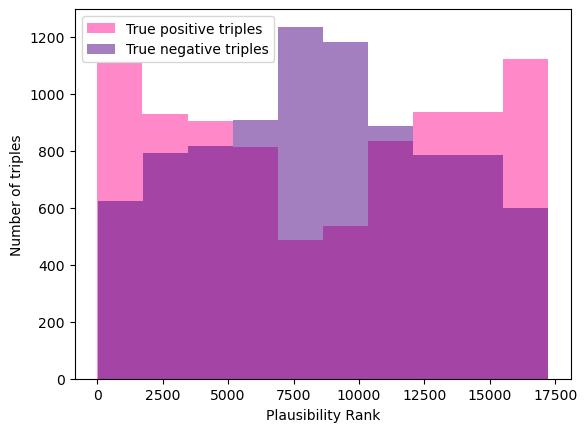

In [67]:
fig, ax = plt.subplots()

ax.hist(gpe_pos_ranks, color='deeppink', alpha=0.5, label='True positive triples')
ax.hist(gpe_neg_ranks, color='indigo', alpha=0.5, label='True negative triples')
ax.set_xlabel('Plausibility Rank')
ax.set_ylabel('Number of triples')
ax.legend()

In [71]:
gpe_neg_scores = gpe_score_df[gpe_score_df['is_negative']].score.tolist()
gpe_pos_scores = gpe_score_df[~gpe_score_df['is_negative']].score.tolist()

Text(0.5, 0.01, 'Score')

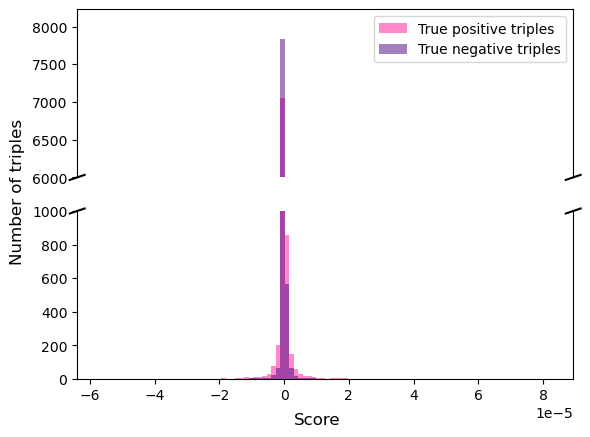

In [72]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

bins = np.histogram(np.hstack((gpe_pos_scores, gpe_neg_scores)), bins=100)[1]

_ = ax1.hist(gpe_pos_scores, bins, color='deeppink', alpha=0.5, label='True positive triples')
_ = ax1.hist(gpe_neg_scores,bins,  color='indigo', alpha=0.5, label='True negative triples')
_ = ax2.hist(gpe_pos_scores, bins, color='deeppink', alpha=0.5, label='True positive triples')
_ = ax2.hist(gpe_neg_scores,bins,  color='indigo', alpha=0.5, label='True negative triples')

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-3]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 1000) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False, top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

_ = ax1.legend(loc='upper right')
fig.supylabel('Number of triples')
fig.supxlabel('Score')

t-test to see if the means of the distributions are the same:

In [73]:
ttest_ind(gpe_pos_scores, gpe_neg_scores)

TtestResult(statistic=0.08048205206054726, pvalue=0.9358548048771755, df=17233.0)

KS test to see if the distributions are the same:

In [74]:
kstest(gpe_pos_scores, gpe_neg_scores)

KstestResult(statistic=0.0993761138539632, pvalue=1.867912265724055e-37, statistic_location=-2.2726642789905327e-09, statistic_sign=1)

### Generating comparable performance metrics for PyKEEN model
We would like to generate an AUROC/PRC curve so that we can compare the rank-based prediction to that of the RF model and the STHN TLP model. The RESCAL authors state that "link prediction can be done by comparing \[the plausibility score\] to some given threshold θ". Therefore, we will generate a set of thresholds and build an AUROC curve, from which we can choose the best threshold and then calculate an F1 score.

Note that this is somewhat different from the RF model in that it's not a multiclass problem: we provided the relation label, and the model is tasked with deciding if the relation is true or not, which makes this a binary problem. We therefore might expect better performance from this model, as it should be easier to decide true vs. false than to have to choose both true vs. false as well as which label it is. This means that we can't directly compare the AUROC's for the two models -- however, it will be helpful to see how this model performs.

#### Drought + DT

In [45]:
pykeen_test = [0 if n else 1 for n in score_df.is_negative]

In [46]:
fpr, tpr, thresholds = roc_curve(pykeen_test, score_df.score)
pykeen_auc = auc(fpr, tpr)
print(f'The PyKEEN RESCAL model has an AUROC of {pykeen_auc:.2f}')

The PyKEEN RESCAL model has an AUROC of 0.51


In [48]:
thresholds

array([           inf,  2.8926038e-06,  1.1281755e-06, ...,
       -1.4147917e-06, -1.4304140e-06, -4.7876929e-06], dtype=float32)

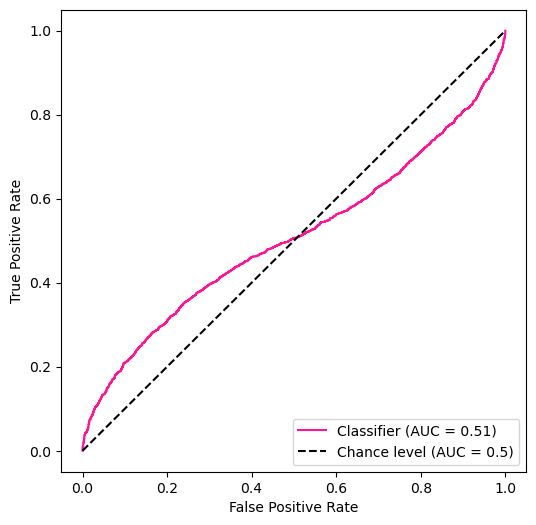

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_predictions(
    pykeen_test,
    score_df.score,
    color='deeppink',
    ax=ax,
    plot_chance_level=True,
)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

#### Genophenoenvo

In [75]:
gpe_pykeen_test = [0 if n else 1 for n in gpe_score_df.is_negative]

In [76]:
gpe_fpr, gpe_tpr, gpe_thresholds = roc_curve(gpe_pykeen_test, gpe_score_df.score)
gpe_pykeen_auc = auc(gpe_fpr, gpe_tpr)
print(f'The PyKEEN RESCAL model has an AUROC of {gpe_pykeen_auc:.2f}')

The PyKEEN RESCAL model has an AUROC of 0.49


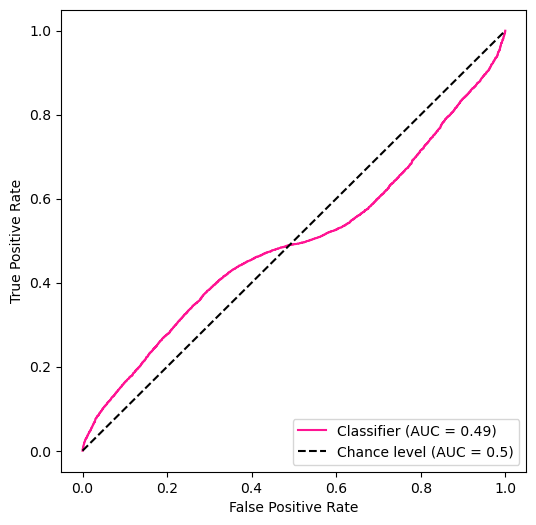

In [77]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_predictions(
    gpe_pykeen_test,
    gpe_score_df.score,
    color='deeppink',
    ax=ax,
    plot_chance_level=True,
)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

### Predicting top 100 triples
If we were to use this method to look for the most probable new connections in the graph without having a previous hypothesis about what kinds of triples we think are most likely to be interesting, we would use `predict_all`. We can just store the top 100 to save on memory, but it doesn't change how many scores have to be calculated. This may prove too computationally challenging, but I would like to try it:

#### Drought + DT

In [ ]:
all_scores = predict.predict_all(
    model=my_model,
    k=100
)

In [11]:
top_100_dt = all_scores.process(tf).df
top_100_dt.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,69982,common scab disease,0,both,34292,b. lactucae,0.000037
1,106967,frankliniella occidentalis pergande,0,both,176129,nbs-lrr disease resistance genes,0.000036
2,258095,sub-saharan african,0,both,252545,soybean cyp707a gene family,0.000035
3,79880,dabz-f1,0,both,252545,soybean cyp707a gene family,0.000034
4,28583,ascophyllum nodosum extracts,0,both,253661,sphagnum peat mesocosms,0.000034


In [12]:
# Save out
top_100_dt.to_csv('../data/ml_outputs/RESCAL_rank_based_top_100_triples_from_predict_all.csv', index=False)

In [37]:
top_100_dt = pd.read_csv('../data/ml_outputs/RESCAL_rank_based_top_100_triples_from_predict_all.csv')

Text(0.5, 0.01, 'Score')

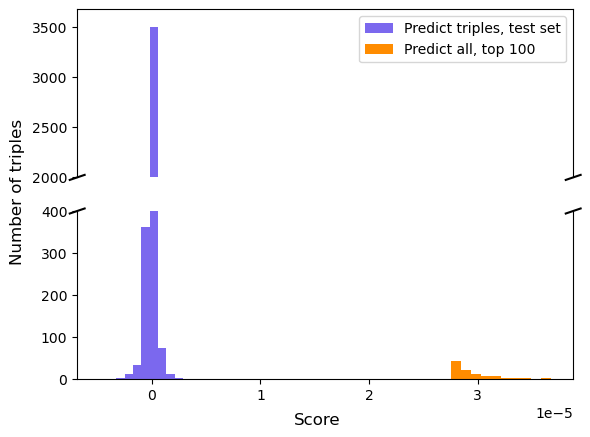

In [38]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(score_df.score, color='mediumslateblue', label='Predict triples, test set')
_ = ax1.hist(top_100_dt.score, color='darkorange', label='Predict all, top 100')
_ = ax2.hist(score_df.score, color='mediumslateblue', label='Predict triples, test set')
_ = ax2.hist(top_100_dt.score, color='darkorange', label='Predict all, top 100')

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-3]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 400) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False, top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

_ = ax1.legend(loc='upper right')
fig.supylabel('Number of triples')
fig.supxlabel('Score')

If we were to perform this on the graph to try and find new hypotheses, these are the best predictions we could expect. We can already see that most of these are either trivial or unrelated to desiccation. We'll do some literature searching to characterize the top 10 most likely triples.

In [43]:
top_10 = top_100_dt[['head_label', 'relation_label', 'tail_label']].copy()
top_10.head(10)

,head_label,relation_label,tail_label
0,common scab disease,both,b. lactucae
1,frankliniella occidentalis pergande,both,nbs-lrr disease resistance genes
2,sub-saharan african,both,soybean cyp707a gene family
3,dabz-f1,both,soybean cyp707a gene family
4,ascophyllum nodosum extracts,both,sphagnum peat mesocosms
5,q. maxima,both,catalase and gr activities
6,medium salt,both,peanut leaves or roots
7,timber revenue,both,brazilian eucalypt plantations
8,hex aquifolium,both,embolism recovery
9,ggcms,both,methyltransferase-2 domains


Since these are labeled as both, let's check whether they originally had a drought label or not:

In [44]:
pair_triples = {(t[0], t[2]): t[1] for t in triples}

In [45]:
def get_original_connection(row, all_trips):
    pair = (row.head_label, row.tail_label)
    try:
        lab = all_trips[pair]
    except KeyError:
        lab = 'negative'
    return lab

In [46]:
top_100_dt['original_connection'] = top_100_dt.apply(get_original_connection, axis=1, all_trips=pair_triples)

Check the number of each original connection type we have in the top 10:

In [49]:
top_100_dt.groupby(by='original_connection').count()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
original_connection,,,,,,,
negative,100,100,100,100,100,100,100


Now check what types they were predicted as:

In [50]:
top_100_dt.groupby(by='relation_label').count()

,head_id,head_label,relation_id,tail_id,tail_label,score,original_connection
relation_label,,,,,,,
both,100,100,100,100,100,100,100


In [47]:
top_10['original_connection'] = top_10.apply(get_original_connection, axis=1, all_trips=pair_triples)

In [48]:
top_10.head(10)

,head_label,relation_label,tail_label,original_connection
0,common scab disease,both,b. lactucae,negative
1,frankliniella occidentalis pergande,both,nbs-lrr disease resistance genes,negative
2,sub-saharan african,both,soybean cyp707a gene family,negative
3,dabz-f1,both,soybean cyp707a gene family,negative
4,ascophyllum nodosum extracts,both,sphagnum peat mesocosms,negative
5,q. maxima,both,catalase and gr activities,negative
6,medium salt,both,peanut leaves or roots,negative
7,timber revenue,both,brazilian eucalypt plantations,negative
8,hex aquifolium,both,embolism recovery,negative
9,ggcms,both,methyltransferase-2 domains,negative


Investigate origin of weird entities:

In [51]:
nx.get_node_attributes(graph, 'uids_of_origin')['q. maxima']

'WOS:000527202100030'

In [52]:
nx.get_node_attributes(graph, 'uids_of_origin')['hex aquifolium']

'WOS:000302592900009'

In [53]:
nx.get_node_attributes(graph, 'uids_of_origin')['ggcms']

'WOS:000770435100001'